# 2 - Image stitching

Utilizar descritores de imagem, como SURF, SIFT ou ORB para identificar descritores similares entre imagens e conecta-las, gerando uma única imagem.

<Figure size 432x288 with 0 Axes>

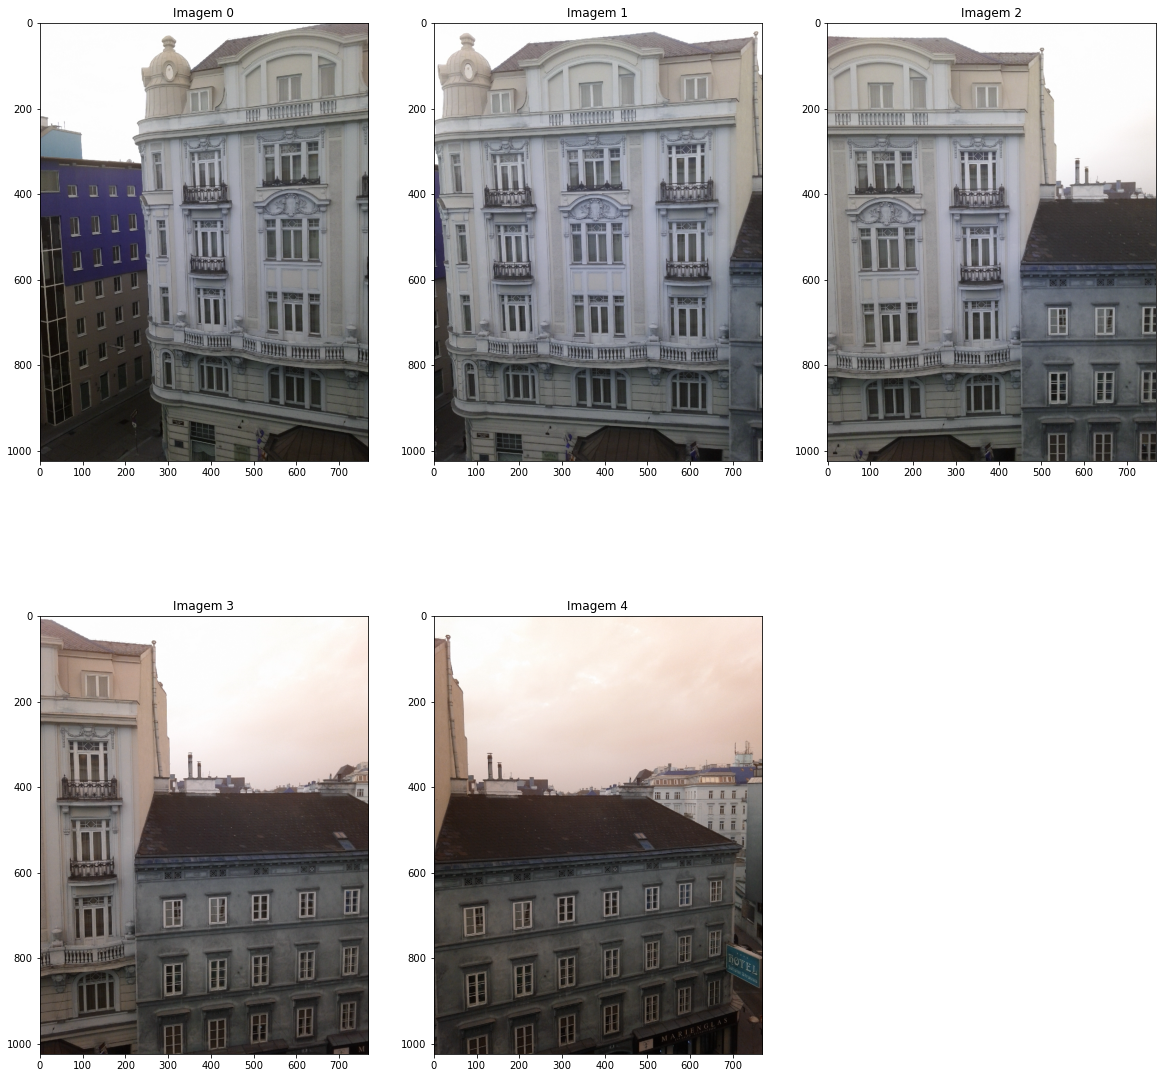

In [22]:
import numpy as np
import cv2 as cv
#Exibição das imagens
plt.figure(1)
#plt.figure(figsize=(10,8))
plt.figure(figsize=(20,20))
images_path = ['img/image1.jpg','img/image2.jpg','img/image3.jpg','img/image4.jpg','img/image5.jpg']
for img_path_index in range(len(images_path)):
    img1 = cv2.imread(images_path[img_path_index])
    #img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    ax1 = plt.subplot(img_path_index+231)
    ax1.set_title("Imagem "+str(img_path_index))
    ax1.imshow(img1)

plt.show()

In [33]:
#!pip install opencv-contrib-python
from matplotlib import pyplot as plt
import cv2
import numpy as np

## Image stitching Usando OpenCv 

A implementação abaixo é baseada na documentação do OpenCv [link](https://docs.opencv.org/master/d5/d48/samples_2python_2stitching_8py-example.html)

In [34]:
class image_stitching():
    def __init__(self):
        pass
    def stitcher_opencv(self,images_path):
        for img_path in images_path:
            dim=(1024,768)
            img = cv2.imread(img_path,cv2.IMREAD_COLOR)
            img = cv2.resize(img,dim,interpolation = cv2.INTER_AREA)
            images_data.append(img)
        stitcher = cv2.Stitcher.create()
        ret,final_img = stitcher.stitch(images_data)
        return ret,final_img

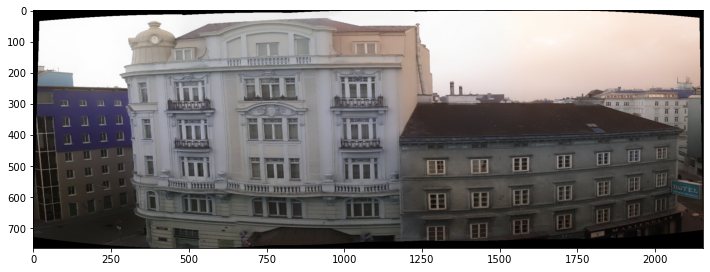

In [35]:
from matplotlib import pyplot as plt
import cv2
plt.figure(figsize=(12,8))

images_path = ['img/image1.jpg','img/image2.jpg','img/image3.jpg','img/image4.jpg','img/image5.jpg']
images_data = []
is_ = image_stitching()
ret, final_img = is_.stitcher_opencv(images_path)
if ret==cv2.STITCHER_OK:
    plt.imshow(final_img)
    plt.show()

## Image stitching Usando alternativo, apenas para duas imagens 

A implementação abaixo é uma adaptação do [link](https://pylessons.com/OpenCV-image-stiching-continue/)

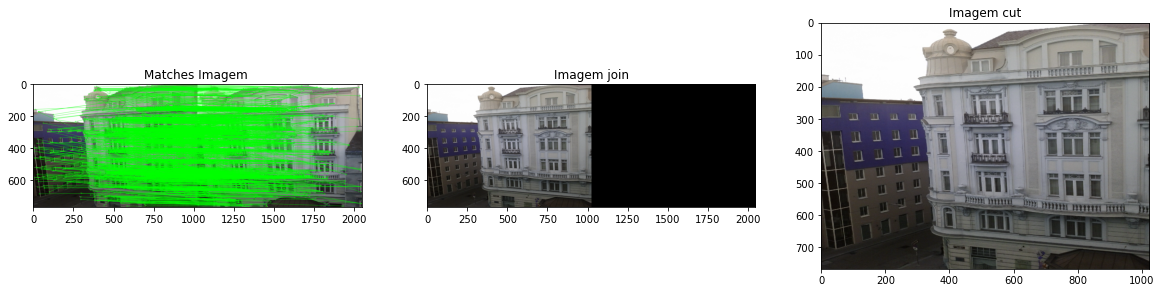

In [37]:
class image_stitching_alternative():
    def __init__(self):
        pass
    def sift(self,images_data):
        kp1_data, des1_data = [], []
        for img_data_index in range(len(images_data)):
            sift = cv2.xfeatures2d.SIFT_create()
            kp1, des1 = sift.detectAndCompute(images_data[img_data_index],None)
            kp1_data.append(kp1)
            des1_data.append(des1)
        return kp1_data, des1_data
    def calc_matcher(self,des1_1, des1_2):
        match = cv2.BFMatcher()
        matches = match.knnMatch(des1_1,des1_2,k=2)
        good = []
        #pegando só os melhores
        for m,n in matches:
            #print(m.distance,n.distance)
            if m.distance < 0.9*n.distance:
                good.append(m)
        return good
    def img_matches(self,img1,img2,kp1_1,kp1_2,good):
        #plt.figure(figsize=(20,20))
        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                           singlePointColor = None,
                           flags = 2)
        img3 = cv2.drawMatches(img1,kp1_1,img2,kp1_2,good,None,**draw_params)
        return img3
        #plt.imshow(img3)
    def join_matches(self,good,kp1_1,kp1_2,img1):
        MIN_MATCH_COUNT = 10
        if len(good) > MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1_1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp1_2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            h,w,xxx = img1.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            img2 = cv2.polylines(img1,[np.int32(dst)],True,255,3, cv2.LINE_AA)
            #plt.imshow(img2)
            #cv2.imshow("original_image_overlapping.jpg", img2)
        else:
            print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        return img2,M, mask
    def img_join(self,img1):
        dst = cv2.warpPerspective(img1,M,(img.shape[1] + img1.shape[1], img1.shape[0]))
        dst[0:img1.shape[0],0:img1.shape[1]] = img1
        #plt.imshow(dst)
        return dst
    def trim(self,frame):
        #crop top
        if not np.sum(frame[0]):
            return self.trim(frame[1:])
        #crop top
        if not np.sum(frame[-1]):
            return self.trim(frame[:-2])
        #crop top
        if not np.sum(frame[:,0]):
            return self.trim(frame[:,1:])
        #crop top
        if not np.sum(frame[:,-1]):
            return self.trim(frame[:,:-2])
        return frame
images_data = []    
images_path = ['img/image1.jpg','img/image2.jpg','img/image3.jpg','img/image4.jpg','img/image5.jpg']
img1 = cv2.imread(images_path[0])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
for img_path in images_path:
    dim=(1024,768)
    img = cv2.imread(img_path,cv2.IMREAD_COLOR)
    img = cv2.resize(img,dim,interpolation = cv2.INTER_AREA)
    images_data.append(img)
fun = image_stitching_alternative()
#calc sift
kp1_data, des1_data = fun.sift(images_data)

good = fun.calc_matcher(des1_data[0],des1_data[1])
img_1 = fun.img_matches(images_data[0],images_data[1],kp1_data[0],kp1_data[1],good)
img_2,M, mask = fun.join_matches(good,kp1_data[0],kp1_data[1],images_data[1])
dst = fun.img_join(images_data[0])
img_3 = fun.trim(dst)

#img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(20,20))
ax1 = plt.subplot(231)
ax1.set_title("Matches Imagem ")
ax1.imshow(img_1)

ax2 = plt.subplot(232)
ax2.set_title("Imagem join")
ax2.imshow(dst)

ax3 = plt.subplot(233)
ax3.set_title("Imagem cut")
ax3.imshow(img_3)

#plt.show()

#plt.imshow(img)
#---------------------------------
#kp1_data, des1_data = fun.sift([img])
#fun.draw_matches(img,images_data[2],kp1_data[1],kp1_data[2],good)
#img2,M, mask = fun.join_matches(good,fun.sift([img]),kp1_data[2],images_data[2])
#dst = fun.draw_img_join(img)
#print(dst)
#img = fun.trim(dst)
#plt.imshow(img)
